In [1]:
import os
import random
from typing import Union
from pathlib import Path

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
!pip install roboflow
from roboflow import Roboflow
rf = Roboflow(api_key=KEY)

Reason for being yanked: deprecated, use 4.8.0.76
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 1.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 3.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 25.6 MB/s eta 0:00:0000:01:00:01
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.10.0.82
    Uninstalling opencv-python-headless-4.10.0.82:
      Successfully uninstalled opencv-python-headless-4.10.0.82
  Attempting uninstall: idna
    Found existing installation: idna 3.6
    Uninstalling idna-3.6:
      Successfully uninstalled idna-3.6
  Attempting uninstall: cycler
    Found existing installation: cycler 0.12.1
    Uninstalling cycler-0.12.1:
      Successfully uninstalled cycler-0.12.1
  Att

# Loading dataset

In [3]:
project = rf.workspace("atco").project("3d-printing-error")
version = project.version(7)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
[WARNING] we noticed you are downloading a `yolov8` datasets but you don't have `ultralytics` installed. Roboflow `.deploy` supports only models trained with `ultralytics==8.0.196`, to intall it `pip install ultralytics==8.0.196`.



Extracting Dataset Version Zip to 3D-printing-error-7 in yolov8:: 100%|██████████| 21521/21521 [00:03<00:00, 6609.71it/s]


# EDA

# View train images

In [4]:
DATA_DIR = "/kaggle/working/3D-printing-error-7/"
TRAIN_DIR, VAL_DIR = os.path.join(DATA_DIR, "train/"), os.path.join(DATA_DIR, "val/")
TRAIN_IMAGES_DIR, TRAIN_LABELS_DIR = os.path.join(TRAIN_DIR, "images/"), os.path.join(TRAIN_DIR, "labels/")

In [5]:
def view_random_images(img_paths, num_images=16):
    """
    Display a specified number of random images from the given dataset.
    """
    random_indices = random.sample(range(len(img_paths)), k=num_images)
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 12))

    for i, idx in enumerate(random_indices):
        img_path = img_paths[idx]
        img = plt.imread(img_path)
        ax = axes[i // 4, i % 4]
        ax.axis('off')
        ax.imshow(img)

    plt.tight_layout()
    plt.show()

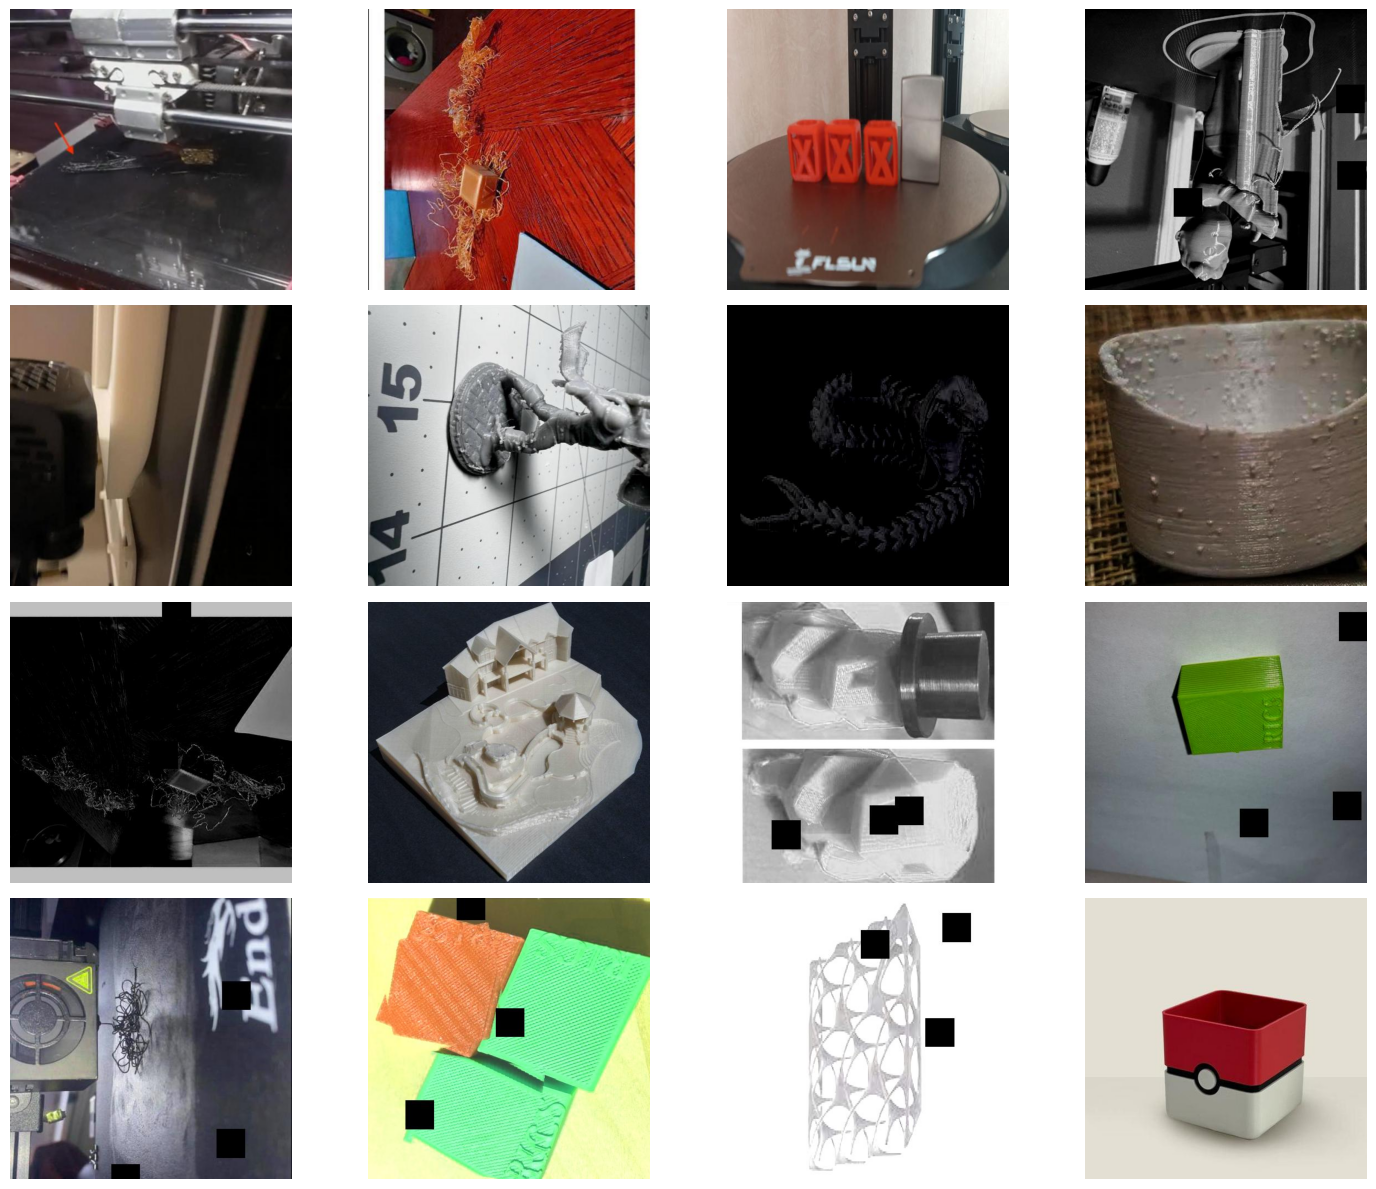

In [7]:
view_random_images([str(path) for path in Path(TRAIN_IMAGES_DIR).glob('*.jpg')])

## Understanding the size of train/val

In [8]:
def count_train_val(data_dir) -> tuple[int, int]:
    """
    Returns the amount of images in train and val directories on the data_dir
    """
    train_dir, val_dir = os.path.join(data_dir, "train/"), os.path.join(data_dir, "valid/")
    # take randomly either data or labels dir and check amount of files
    train_data_amount = len(os.listdir(train_dir + os.listdir(train_dir)[0]))
    val_data_amount = len(os.listdir(val_dir + os.listdir(val_dir)[0]))
    
    return (train_data_amount, val_data_amount)

In [9]:
train_data_amount, val_data_amount = count_train_val(DATA_DIR)
print(f"Train dataset contains {train_data_amount} images")
print(f"Validation dataset contains {val_data_amount} images")

Train dataset contains 9723 images
Validation dataset contains 1033 images


## Getting the training data distribution

In [10]:
def replace_ext(filepath:str, new_ext:str) -> tuple[str, bool]:
    """Function that replaces current file extension to a new extension (new_ext)"""
    new_filepath = os.path.splitext(filepath)[0] + f"{new_ext}"
    return new_filepath, os.path.isfile(new_filepath)


def replace_directory(filepath:str, new_directory:str) -> tuple[str, bool]:
    """Function that replaces the last dir in file path to a new directory."""
    filepath_splitted = filepath.split("/")
    filepath_without_last_dir, filename = "/".join(filepath_splitted[:-2]), filepath_splitted[-1]
    new_filepath = os.path.join(filepath_without_last_dir, new_directory)
    new_filepath = os.path.join(new_filepath, filename)
    return new_filepath, os.path.isfile(new_filepath)

In [11]:
def extract_paths_from_directory(directory:str) -> list[str]:
    """List filenames from directory and add directory path to it"""
    return [os.path.join(directory, file) for file in os.listdir(directory)]


def get_label_by_image(labels_dir:str, image_path:str) -> tuple[str, bool]:
    labels_dir_name = labels_dir.split("/")[-2]
    label_path = replace_directory(image_path, labels_dir_name)[0]
    label_path = replace_ext(label_path, ".txt")[0]
    return label_path, os.path.isfile(label_path)

In [12]:
def is_empty(label_file_path:str) -> bool:
    with open(label_file_path, 'r') as f:
        lines = f.readlines()
    return len(lines) == 0


def count_empty(labels_dir:str) -> int:
    counter=0
    for file in os.listdir(labels_dir):
        file_path = os.path.join(labels_dir, file)
        if is_empty(file_path):
            counter+=1
    return counter


def get_empty(label_dir:str, image_dir:str) -> tuple[list[str], list[str]]:
    images = [os.path.join(image_dir, image_filepath) for image_filepath in os.listdir(image_dir)]
    labels = [get_label_by_image(label_dir, image_path)[0] for image_path in images]
    empty_images, empty_labels = [], []
    for i,label in enumerate(labels):
        if is_empty(label):
            empty_labels.append(label)
            empty_images.append(images[i])
    return empty_images, empty_labels

In [13]:
def check_class_distribution(labels: Union[list[str], str]) -> dict:
    """
     Iterate through each annotation file in list, extracting all mentioned classes,
     Determine the number of occurrences for each class and increment their respective counters in the dictionary.
    """
    # if type(labels) == str the path to label_dir was passed and we need to form list wit listdir
    if type(labels) == str:
        labels_list = extract_paths_from_directory(labels)
    else:
        labels_list = labels
        
    classes = {} # dict with all classes as keys and their mentions across train dataset in values
    
    def process_annotation_file(filepath:str) -> None:
        """
        Helper function for extracting mentioned classes in annotation file andincrementing global classes dictionary.
        """
        with open(filepath, 'r') as f:
            lines = f.readlines()
            for line in lines:
                obj_id = int(line.split()[0])  # Convert to integer immediately for proper handling of string vs numeric IDs
                classes[obj_id] = classes.get(obj_id, 0) + 1

    # processing all annotations in labels_dir.         
    for annotation_file in labels_list:
        process_annotation_file(annotation_file)
    
    return classes 


def count_classes_without_repetition(labels_dir: str) -> dict:  
    # Initialize an empty dictionary to store the class counts
    class_counts = {}
    # Iterate through all annotation files
    for file in os.listdir(labels_dir):
        with open(os.path.join(labels_dir, file), 'r') as f:
            classes_in_image = set()  # use a set to avoid duplicates
            for line in f:
                class_name = line.strip().split()[0]  # assuming class name is the first token
                classes_in_image.add(class_name)
            for class_name in classes_in_image:
                if class_name not in class_counts:
                    class_counts[class_name] = 1
                else:
                    class_counts[class_name] += 1
    return class_counts


def form_annotation_file_stat(filepath) -> dict:
    """
    Forms statistics about what classes are mentioned in the annotation file
    """
    file_classes = {}
    with open(filepath, 'r') as f:
        lines = f.readlines()
        for line in lines:
            obj_id = int(line.split()[0])  # Convert to integer immediately for proper handling of string vs numeric IDs
            file_classes[obj_id] = file_classes.get(obj_id, 0) + 1
                        
    return dict((k, v) for k,v in file_classes.items() if k > 0)


def form_annotation_file_stat_with_percentage(filepath:str) -> dict:
    """
    Forms statistics about what classes are mentioned in the annotation file
    including the ratio of mentions for each class.
    """
    file_classes = form_annotation_file_stat(filepath)
    total_mentions = sum(file_classes.values())

    file_classes_with_percentage = {}
    for class_id, mention_count in file_classes.items():
        file_classes_with_percentage[class_id] = {'mention_count': mention_count, 'percentage': mention_count / total_mentions}

    return file_classes_with_percentage

In [14]:
def has_different_errors(filepath:str) -> bool:
    """
    Returns True if there're different classes of errors in the label file
    """
    return len(form_annotation_file_stat(filepath).keys()) > 1


def get_imgs_with_different_error_types(labels_dir:str, images_dir:str) -> list:
    """
    Returns pathes for all images that have multiple classes of 3D printing defects
    """
    imgs_with_different_defects = []
    for file in os.listdir(labels_dir):
        label_file_path = os.path.join(labels_dir, file)
        if os.path.isfile(label_file_path) and has_different_errors(label_file_path):
            image_file_name = os.path.splitext(label_file_path)[0].split("/")[-1]
            image_path = os.path.join(images_dir, image_file_name + ".jpg")
            if os.path.isfile(image_path):
                imgs_with_different_defects.append(image_path) 
    return imgs_with_different_defects


def check_different_error_types(labels_dir:str) -> int:
    """
    Returns number of labels that contain multiple classes of 3dprinting defects
    """
    count = 0
    for file in os.listdir(labels_dir):
        label_file_path = os.path.join(labels_dir, file)
        if os.path.isfile(label_file_path) and has_different_errors(label_file_path):
            count+=1
    
    return count

### Error distribution in train
Let's firstly check how many files do have anmy kind of 3D printing error.

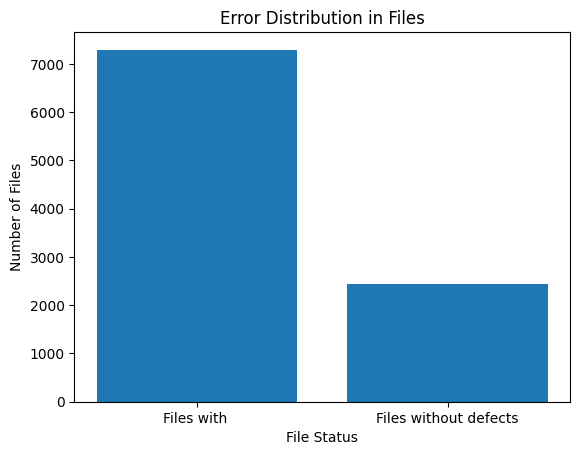

In [15]:
fig, ax = plt.subplots()

labels = ['Files with ', 'Files without defects']
no_errors_amount = count_empty(TRAIN_LABELS_DIR)
values = [train_data_amount - no_errors_amount, no_errors_amount]

ax.bar(labels, values)


ax.set_title('Error Distribution in Files')
ax.set_xlabel('File Status')
ax.set_ylabel('Number of Files')


plt.show()

### Defect classes distribution

In [16]:
def draw_classes_hist(classes_mentions_dict) -> None:
    """
    Plot histogram for classes mentioned in some data samples
    """
    keys = list(classes_mentions_dict.keys())
    values = list(classes_mentions_dict.values())

    plt.bar(keys, values)
    plt.xlabel("Classes")
    plt.ylabel("Count")
    plt.title("Histogram of Class Counts")
    plt.show()

In [17]:
classes = check_class_distribution(TRAIN_LABELS_DIR)
classes = dict(sorted(classes.items()))
print(classes)
None

{0: 2520, 1: 9612, 2: 2367, 3: 1194, 4: 28992}


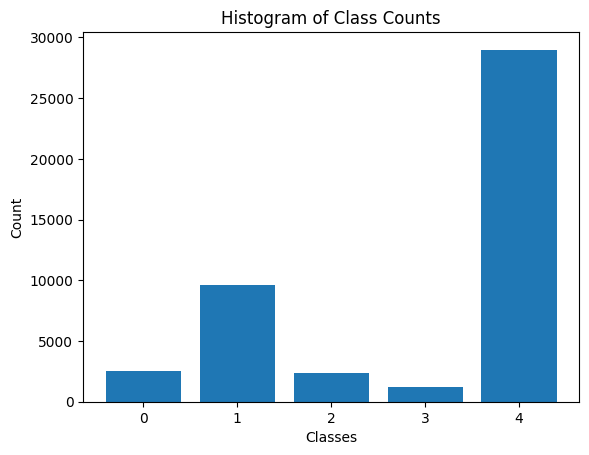

In [18]:
draw_classes_hist(classes)

It can be seen that there're much more mentions then images in the dataset. So let's count only the first occurance of a defect type and see the histogram dist.

In [19]:
count_by_annotation_file = dict(sorted(count_classes_without_repetition(TRAIN_LABELS_DIR).items()))

print(count_by_annotation_file)
None

{'0': 663, '1': 4353, '2': 669, '3': 669, '4': 1077}


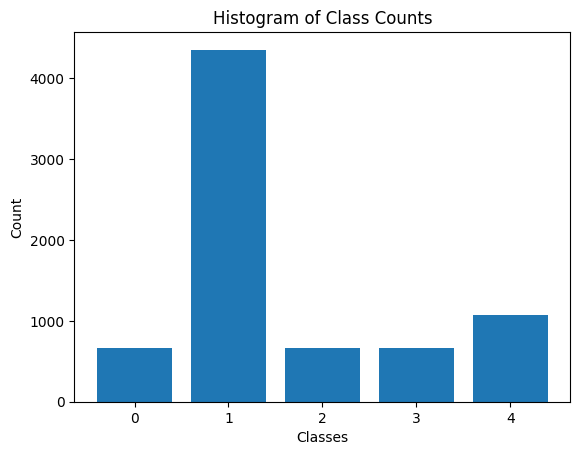

In [20]:
draw_classes_hist(count_by_annotation_file)

### Single/Multiple classes of defects per image

It's interesting, in how many labels there are different classes of defects. And what is the class distribution among these label files

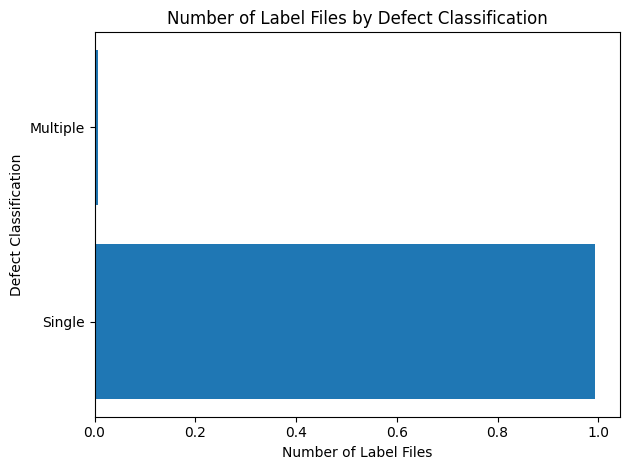

In [21]:
# Plot the distribution of images that have single vs multiple types of deffect
multiple_defected_amount = check_different_error_types(TRAIN_LABELS_DIR)
single_defected_amount = train_data_amount - multiple_defected_amount

categories = np.array(["Single", "Multiple"])
counts = np.array([single_defected_amount, multiple_defected_amount])/train_data_amount

fig, ax = plt.subplots()
ax.barh(categories, counts)
ax.set_xlabel("Number of Label Files")
ax.set_ylabel("Defect Classification")
ax.set_title("Number of Label Files by Defect Classification")
plt.tight_layout()
plt.show()

It can be seen that mostly we have one class on defect per image. Being precise: only 66 images have several types of 3d printing errors.

Also let's see what is the distribution between classes of errors among only multiple defected models.

In [22]:
#Load images with several classes of 3d printing errors and their labels 
imgs_with_different_error_types = get_imgs_with_different_error_types(TRAIN_LABELS_DIR, TRAIN_IMAGES_DIR)
labels_with_different_error_types = [get_label_by_image(TRAIN_LABELS_DIR, image_path)[0] for image_path in imgs_with_different_error_types]

In [23]:
multiple_defects_classes = dict(sorted(check_class_distribution(labels_with_different_error_types).items())) # calculate distribution for only imgs with different defect types mentioned

In [24]:
print(multiple_defects_classes)

{0: 9, 1: 105, 2: 138, 3: 21, 4: 981}


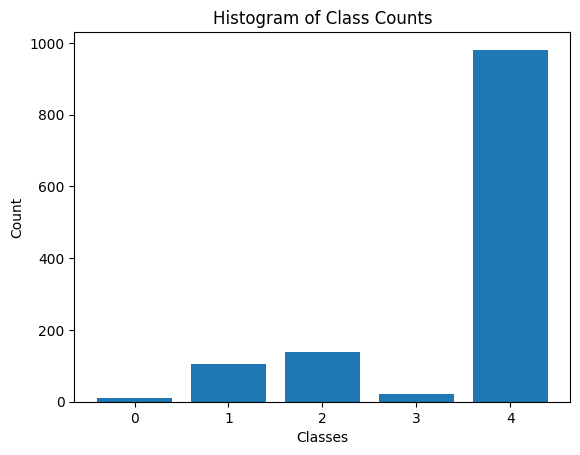

In [26]:
draw_classes_hist(multiple_defects_classes) # plot the distribution of defects among only the imgs with several classes of defects

### Cutting empty images from train dataset

In [27]:
def delete_empty_images_with_labels(label_dir:str, image_dir:str) -> int:
    empty_images, empty_labels = get_empty(label_dir, image_dir)
    removed_amount = 0
    for k,image in enumerate(empty_images):
        os.remove(image)
        os.remove(empty_labels[k])
        removed_amount+=1
    return removed_amount 

In [28]:
empty_removed_amount = delete_empty_images_with_labels(TRAIN_LABELS_DIR, TRAIN_IMAGES_DIR)
print(f"From train data were deleted {empty_removed_amount}")

From train data were deleted 2430


In [29]:
train_data_amount = count_train_val(DATA_DIR)[0]
print(f"train dataset from now contains {train_data_amount} images")

None

train dataset from now contains 7293 images


## Cutting the train dataset for data to have equally proportion of classes

In [30]:
def get_dominated_class(label_filepath:str) -> tuple[int, bool]:
    class_stats = form_annotation_file_stat_with_percentage(label_filepath)
    dominator = 0
    biggest_class_percent = -100
    for k, v in class_stats.items():
        if v["percentage"] > biggest_class_percent:
            biggest_class_percent = v["percentage"]
            dominator = k
    return dominator, biggest_class_percent >= 0.998

In [33]:
get_dominated_class(labels_with_different_error_types[43])

(4, False)

In [34]:
def reduce_train_dataset(label_dir, image_dir, reduce_class_num, reduce_amount) -> int:
    images = [os.path.join(image_dir, image_filepath) for image_filepath in os.listdir(image_dir)]
    labels = [get_label_by_image(label_dir, image_path)[0] for image_path in images]
    print(len(labels))
    removed_amount = 0
    for i,label in enumerate(labels):
        dominator_class, is_absolute_dominator = get_dominated_class(label)
        if (dominator_class == reduce_class_num) and is_absolute_dominator:
            if removed_amount < reduce_amount:
                os.remove(label)
                os.remove(images[i])
                removed_amount += 1
    return removed_amount

In [34]:
reduce_train_dataset(TRAIN_LABELS_DIR, TRAIN_IMAGES_DIR, 4, 400)

7293


400